<a href="https://colab.research.google.com/github/pathu11/NMT-Training-Speech-to-Text-Convertion/blob/main/nmt_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

! pip install sympy
! pip install torch torchvision torchaudio

In [2]:
! pip show sympy --version

Name: sympy
Version: 1.13.3
Summary: Computer algebra system (CAS) in Python
Home-page: https://sympy.org
Author: SymPy development team
Author-email: sympy@googlegroups.com
License: BSD
Location: /usr/local/lib/python3.12/dist-packages
Requires: mpmath
Required-by: torch


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

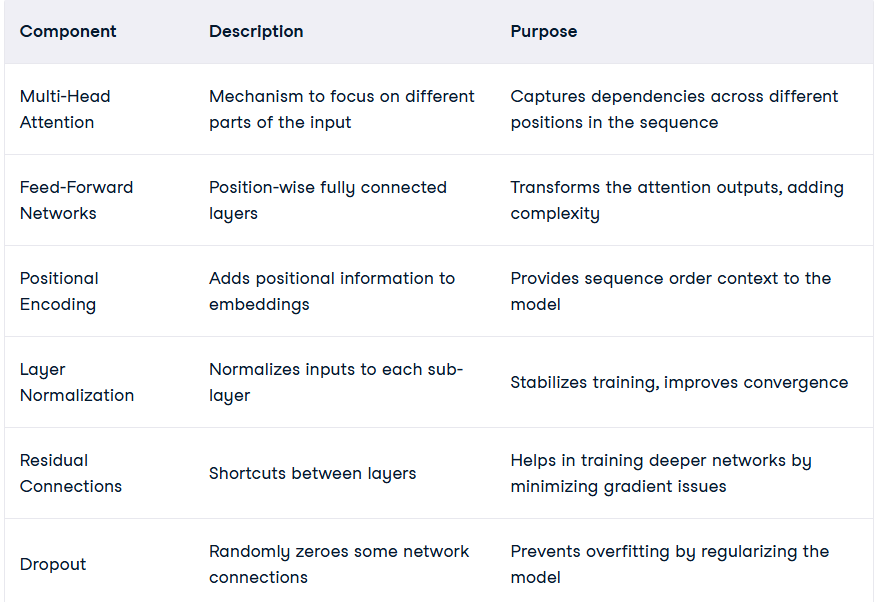

In [4]:
class MultiHeadAttention(nn.Module):
  """
    The class is defined as a subclass of PyTorch's nn.Module.

    d_model: Dimensionality of the input.
    num_heads: The number of attention heads to split the input into.
    The initialization checks if d_model is divisible by num_heads, and then defines the transformation weights for query, key, value, and output.
  """

  def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation

  def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output

  def split_heads(self, x):
    """This method reshapes the input x into the shape (batch_size, num_heads, seq_length, d_k).
    It enables the model to process multiple attention heads concurrently, allowing for parallel computation.
    """
      # Reshape the input to have num_heads for multi-head attention
    batch_size, seq_length, d_model = x.size()
    return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

  def combine_heads(self, x):
    """After applying attention to each head separately,
    this method combines the results back into a single tensor of shape (batch_size, seq_length, d_model).
    This prepares the result for further processing."""
      # Combine the multiple heads back to original shape
    batch_size, _, seq_length, d_k = x.size()
    return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

  def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

In summary, the PositionWiseFeedForward class defines a position-wise feed-forward neural network that consists of two linear layers with a ReLU activation function in between. In the context of transformer models, this feed-forward network is applied to each position separately and identically. It helps in transforming the features learned by the attention mechanisms within the transformer, acting as an additional processing step for the attention outputs.

In [5]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        """
        d_model: Dimensionality of the model's input and output.
        d_ff: Dimensionality of the inner layer in the feed-forward network.
        self.fc1 and self.fc2: Two fully connected (linear) layers with input and output dimensions as defined by d_model and d_ff.
        self.relu: ReLU (Rectified Linear Unit) activation function, which introduces non-linearity between the two linear layers.
        """
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        x: The input to the feed-forward network.
        self.fc1(x): The input is first passed through the first linear layer (fc1).
        self.relu(...): The output of fc1 is then passed through a ReLU activation function. ReLU replaces all negative values with zeros, introducing non-linearity into the model.
        self.fc2(...): The activated output is then passed through the second linear layer (fc2), producing the final output.
        """
        return self.fc2(self.relu(self.fc1(x)))

The PositionalEncoding class adds information about the position of tokens within the sequence. Since the transformer model lacks inherent knowledge of the order of tokens (due to its self-attention mechanism), this class helps the model to consider the position of tokens in the sequence. The sinusoidal functions used are chosen to allow the model to easily learn to attend to relative positions, as they produce a unique and smooth encoding for each position in the sequence.

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        """
          d_model: The dimension of the model's input.
          max_seq_length: The maximum length of the sequence for which positional encodings are pre-computed.
          pe: A tensor filled with zeros, which will be populated with positional encodings.
          position: A tensor containing the position indices for each position in the sequence.
          div_term: A term used to scale the position indices in a specific way.
        The sine function is applied to the even indices and the cosine function to the odd indices of pe.
        Finally, pe is registered as a buffer, which means it will be part of the module's state but will not be considered a trainable parameter.
        """
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [7]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        """
        Parameters:

          d_model: The dimensionality of the input.
          num_heads: The number of attention heads in the multi-head attention.
          d_ff: The dimensionality of the inner layer in the position-wise feed-forward network.
          dropout: The dropout rate used for regularization.
        Components:

          self.self_attn: Multi-head attention mechanism.
          self.feed_forward: Position-wise feed-forward neural network.
          self.norm1 and self.norm2: Layer normalization, applied to smooth the layer's input.
          self.dropout: Dropout layer, used to prevent overfitting by randomly setting some activations to zero during training.
        """
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

The DecoderLayer class defines a single layer of the transformer's decoder. It consists of a multi-head self-attention mechanism, a multi-head cross-attention mechanism (that attends to the encoder's output), a position-wise feed-forward neural network, and the corresponding residual connections, layer normalization, and dropout layers. This combination enables the decoder to generate meaningful outputs based on the encoder's representations, taking into account both the target sequence and the source sequence. As with the encoder, multiple decoder layers are typically stacked to form the complete decoder part of a transformer model.

In [8]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [9]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        """
        The constructor takes the following parameters:

          src_vocab_size: Source vocabulary size.
          tgt_vocab_size: Target vocabulary size.
          d_model: The dimensionality of the model's embeddings.
          num_heads: Number of attention heads in the multi-head attention mechanism.
          num_layers: Number of layers for both the encoder and the decoder.
          d_ff: Dimensionality of the inner layer in the feed-forward network.
          max_seq_length: Maximum sequence length for positional encoding.
          dropout: Dropout rate for regularization.
        And it defines the following components:

        self.encoder_embedding: Embedding layer for the source sequence.
        self.decoder_embedding: Embedding layer for the target sequence.
        self.positional_encoding: Positional encoding component.
        self.encoder_layers: A list of encoder layers.
        self.decoder_layers: A list of decoder layers.
        self.fc: Final fully connected (linear) layer mapping to target vocabulary size.
        self.dropout: Dropout layer.
        """
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        """
        This method is used to create masks for the source and target sequences,
        ensuring that padding tokens are ignored and that future tokens are not visible during training for the target sequence."""
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

In [10]:
src_vocab_size = 10000
tgt_vocab_size = 2000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
# src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
# print(src_data)
# tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

In [11]:
def load_custom_dataset(path):
    src_list = []
    tgt_list = []

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if "@" not in line:
                continue

            src, tgt = line.strip().split("@")
            tgt = tgt.split("|")

            ids = []
            for tok in tgt:
                left = tok.split(":")[0]
                if left.isdigit():
                    ids.append(int(left))
                else:
                    ids.append(3)   # unk = 3

            src_list.append(src.strip())
            tgt_list.append(ids)

    return src_list, tgt_list


In [12]:
class SinhalaTokenizer:
    def __init__(self):
        self.w2i = {"<pad>":0, "<bos>":1, "<eos>":2, "<unk>":3}
        self.i2w = {0:"<pad>",1:"<bos>",2:"<eos>",3:"<unk>"}
        self.next_id = 4

    def build(self, sentences):
        for s in sentences:
            for w in s.split():
                if w not in self.w2i:
                    self.w2i[w] = self.next_id
                    self.i2w[self.next_id] = w
                    self.next_id += 1

    def encode(self, text):
        ids = [1]  # <bos>
        for w in text.split():
            ids.append(self.w2i.get(w, 3))
        ids.append(2)  # <eos>
        return ids


In [13]:
class MyDataset(data.Dataset):
    def __init__(self, src_texts, tgt_ids, tokenizer):
        self.src = src_texts
        self.tgt = tgt_ids
        self.tok = tokenizer

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        s = self.tok.encode(self.src[idx])
        t = [1] + self.tgt[idx] + [2]  # bos + target + eos
        return torch.tensor(s), torch.tensor(t)

In [14]:
def collate_fn(batch):
    srcs, tgts = zip(*batch)

    max_s = max(len(s) for s in srcs)
    max_t = max(len(t) for t in tgts)

    padded_s = []
    padded_t = []

    for s, t in zip(srcs, tgts):
        ps = torch.cat([s, torch.zeros(max_s - len(s), dtype=torch.long)])
        pt = torch.cat([t, torch.zeros(max_t - len(t), dtype=torch.long)])
        padded_s.append(ps)
        padded_t.append(pt)

    return torch.stack(padded_s), torch.stack(padded_t)


In [15]:
src_sentences, tgt_ids = load_custom_dataset("/content/drive/MyDrive/research/model/merged_f.txt")

tokenizer = SinhalaTokenizer()
tokenizer.build(src_sentences)

dataset = MyDataset(src_sentences, tgt_ids, tokenizer)
loader = data.DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

In [16]:
import sympy
sympy.__version__



'1.13.3'

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os

# ---------------------------
# CONFIG
# ---------------------------

num_epochs = 10
checkpoint_path = "/content/drive/MyDrive/research/model/transformer_checkpoints"
os.makedirs(checkpoint_path, exist_ok=True)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

start_epoch = 0
global_step = 0   # allows resuming mid-epoch
last_batch_idx = 0

# ---------------------------
# LOAD CHECKPOINT IF AVAILABLE
# ---------------------------

latest_ckpt = checkpoint_path + "/latest.pt"

if os.path.exists(latest_ckpt):
    print("🔄 Loading previous checkpoint...")
    checkpoint = torch.load(latest_ckpt, map_location="cpu")

    transformer.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"]
    global_step = checkpoint["global_step"]
    last_batch_idx = checkpoint["batch_idx"]

    print(f"✔ Resumed from epoch {start_epoch}, batch {last_batch_idx}, step {global_step}")
else:
    print("⏳ No checkpoint found — starting fresh.")


# ---------------------------
# TRAINING LOOP
# ---------------------------

transformer.train()

for epoch in range(start_epoch, num_epochs):
    total_loss = 0
    progress = tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, (src_data, tgt_data) in progress:

        # SKIP ALREADY COMPLETED BATCHES
        if epoch == start_epoch and batch_idx < last_batch_idx:
            continue

        optimizer.zero_grad()

        # model forward
        output = transformer(src_data, tgt_data[:, :-1])

        loss = criterion(
            output.contiguous().view(-1, tgt_vocab_size),
            tgt_data[:, 1:].contiguous().view(-1)
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        global_step += 1

        progress.set_postfix({"loss": total_loss / (batch_idx + 1)})

        # ------------------------
        # SAVE CHECKPOINT EVERY N STEPS
        # ------------------------
        if global_step % 200 == 0:  # adjust if needed
            torch.save({
                "model_state": transformer.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "epoch": epoch,
                "batch_idx": batch_idx,
                "global_step": global_step,
            }, latest_ckpt)
            print("💾 Saved checkpoint.")

    # save checkpoint at end of epoch
    torch.save({
        "model_state": transformer.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "epoch": epoch + 1,
        "batch_idx": 0,
        "global_step": global_step,
    }, latest_ckpt)

    print(f"🔥 Epoch {epoch+1} completed | Avg Loss: {total_loss / len(loader)}")
    last_batch_idx = 0  # reset after epoch


🔄 Loading previous checkpoint...
✔ Resumed from epoch 9, batch 5918, step 70600


Epoch 10/10:  85%|████████▌ | 6118/7184 [03:24<44:54,  2.53s/it, loss=0.00142]

💾 Saved checkpoint.


Epoch 10/10:  88%|████████▊ | 6318/7184 [06:48<22:20,  1.55s/it, loss=0.00266]

💾 Saved checkpoint.


Epoch 10/10:  91%|█████████ | 6518/7184 [10:17<22:38,  2.04s/it, loss=0.00392]

💾 Saved checkpoint.


Epoch 10/10:  94%|█████████▎| 6718/7184 [13:44<12:45,  1.64s/it, loss=0.00509]

💾 Saved checkpoint.


Epoch 10/10:  96%|█████████▋| 6918/7184 [17:13<09:58,  2.25s/it, loss=0.00602]

💾 Saved checkpoint.


Epoch 10/10:  99%|█████████▉| 7118/7184 [20:41<01:43,  1.57s/it, loss=0.00704]

💾 Saved checkpoint.


Epoch 10/10: 100%|██████████| 7184/7184 [21:54<00:00,  5.46it/s, loss=0.00737]


🔥 Epoch 10 completed | Avg Loss: 0.007369403352496985


In [18]:
# Evaluate the model
results = transformer.eval()
print(results)

Transformer(
  (encoder_embedding): Embedding(10000, 512)
  (decoder_embedding): Embedding(2000, 512)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-5): 6 x DecoderLayer(


In [20]:
import json

# 1. Save the Tokenizer
def save_tokenizer(tokenizer, path):
    data = {
        "w2i": tokenizer.w2i,
        "i2w": {int(k): v for k, v in tokenizer.i2w.items()}, # Ensure keys are integers for JSON
        "next_id": tokenizer.next_id
    }
    with open(path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    print(f"Tokenizer saved to {path}")

# 2. Load the Tokenizer
def load_tokenizer(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Reconstruct the class
    tokenizer = SinhalaTokenizer()
    tokenizer.w2i = data["w2i"]
    # Convert keys back to integers (JSON loads dict keys as strings)
    tokenizer.i2w = {int(k): v for k, v in data["i2w"].items()}
    tokenizer.next_id = data["next_id"]
    return tokenizer

# Usage: Save your current trained tokenizer
save_path = "/content/drive/MyDrive/research/model/sinhala_tokenizer.json"
save_tokenizer(tokenizer, save_path)

Tokenizer saved to /content/drive/MyDrive/research/model/sinhala_tokenizer.json


In [21]:
def greedy_decode(model, src, tokenizer, max_len=50, device='cpu'):
    """
    1. Encode the source sentence.
    2. Run through encoder.
    3. Feed decoder one token at a time until <eos> is produced.
    """
    model.eval()

    # 1. Tokenize and convert to tensor
    src_ids = tokenizer.encode(src)
    src_tensor = torch.tensor(src_ids).unsqueeze(0).to(device) # (1, seq_len)

    # 2. Create Source Mask
    src_mask = (src_tensor != 0).unsqueeze(1).unsqueeze(2).to(device)

    # 3. Compute Encoder Output (we compute this only once)
    with torch.no_grad():
        src_embedded = model.dropout(model.positional_encoding(model.encoder_embedding(src_tensor)))
        enc_output = src_embedded
        for enc_layer in model.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

    # 4. Initialize Decoder Input with <bos> (index 1)
    decoder_input = torch.tensor([[1]]).to(device)

    generated_tokens = []

    # 5. Loop to generate tokens
    for _ in range(max_len):
        # Create Target Mask
        tgt_mask = (decoder_input != 0).unsqueeze(1).unsqueeze(3)
        seq_length = decoder_input.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(device)
        tgt_mask = tgt_mask & nopeak_mask

        # Run Decoder
        with torch.no_grad():
            tgt_embedded = model.dropout(model.positional_encoding(model.decoder_embedding(decoder_input)))
            dec_output = tgt_embedded
            for dec_layer in model.decoder_layers:
                dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

            # Project to vocabulary
            output = model.fc(dec_output) # (1, seq_len, vocab_size)

        # Get the token with the highest probability for the LAST position
        next_token_logits = output[:, -1, :]
        next_token_id = next_token_logits.argmax(dim=-1).item()

        # Stop if <eos> (index 2) is generated
        if next_token_id == 2:
            break

        # Append to list and decoder input
        generated_tokens.append(next_token_id)
        decoder_input = torch.cat([decoder_input, torch.tensor([[next_token_id]]).to(device)], dim=1)

    return generated_tokens

In [22]:
# 1. Load Test Data
test_file_path = "/content/drive/MyDrive/research/model/test_data.txt" # Change this to your test file
# Assuming test file format is same as training: Input @ Target

# 2. Load the tokenizer (or use the one currently in memory)
loaded_tokenizer = load_tokenizer(save_path)

# 3. Evaluation Loop
print("------------------------------------------------")
print("STARTING EVALUATION")
print("------------------------------------------------")

transformer.eval() # Set model to eval mode
device = 'cpu' # Or 'cuda' if you are using GPU

# Let's say we pick 5 random examples from your existing dataset for a quick check
# Or load new lines from your test file
import random

# Example: Picking from the list you already loaded, or load new ones
test_indices = random.sample(range(len(src_sentences)), 5)

for idx in test_indices:
    input_text = src_sentences[idx]
    actual_target_ids = tgt_ids[idx]

    # Run Inference
    predicted_ids = greedy_decode(transformer, input_text, loaded_tokenizer, max_len=50, device=device)

    print(f"Input:    {input_text}")
    print(f"Actual:   {actual_target_ids}")
    print(f"Predicted:{predicted_ids}")
    print("-" * 30)

------------------------------------------------
STARTING EVALUATION
------------------------------------------------
Input:    අම්මා ඊයේ කොහේද ගියේ?
Actual:   [435, 894, 39, 354, 1063]
Predicted:[435, 894, 39, 354, 1063]
------------------------------
Input:    දූම්රිය රියදුරු වෛද්‍යවරයාව හමුවීමට ගියා.
Actual:   [98, 3, 3, 354, 1063]
Predicted:[98, 3, 3, 354, 1063]
------------------------------
Input:    නැන්දා රබන් ගහනවා.
Actual:   [443, 264]
Predicted:[443, 264]
------------------------------
Input:    කිමිදුම් කරු යමු.
Actual:   [107, 1060]
Predicted:[107, 1060]
------------------------------
Input:    වේටර්ගේ තාත්තා බඩු ඇද්දා.
Actual:   [125, 1048, 436, 285, 1063]
Predicted:[125, 1048, 436, 285, 1063]
------------------------------


In [23]:
def ids_to_text(id_list, tokenizer):
    # Filter out special tokens: <pad>(0), <bos>(1), <eos>(2), <unk>(3)
    # Note: Your tokenizer.i2w converts IDs back to words
    words = []
    for idx in id_list:
        if idx not in [0, 1, 2, 3]:
            words.append(tokenizer.i2w.get(idx, ""))
    return " ".join(words)

In [24]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 27.7 MB/s eta 0:00:00


In [25]:
from torchmetrics.text import BLEUScore
from tqdm import tqdm

def evaluate_model(model, src_sentences, tgt_ids, tokenizer, device='cpu'):
    model.eval()
    bleu = BLEUScore()

    predicted_sentences = []
    actual_sentences = []

    # Loop through the whole test set (or a large slice of it)
    print("Generating predictions...")
    for i in tqdm(range(len(src_sentences))):
        src_text = src_sentences[i]
        target_id_list = tgt_ids[i]

        # 1. Get Prediction (Greedy Decode)
        pred_ids = greedy_decode(model, src_text, tokenizer, max_len=50, device=device)

        # 2. Convert IDs to Strings (BLEU compares strings/lists of tokens)
        # We convert the list of IDs to a string representation for comparison
        pred_str = " ".join([str(x) for x in pred_ids if x not in [0,1,2]])
        target_str = " ".join([str(x) for x in target_id_list])

        predicted_sentences.append(pred_str)
        actual_sentences.append([target_str]) # BLEU expects a list of references

    # 3. Calculate Score
    score = bleu(predicted_sentences, actual_sentences)
    print(f"-------------------------------")
    print(f"Final BLEU Score: {score.item():.4f}")
    print(f"-------------------------------")

    # Show a few examples
    for i in range(3):
        print(f"Src: {src_sentences[i]}")
        print(f"Ref: {actual_sentences[i][0]}")
        print(f"Pred: {predicted_sentences[i]}")
        print("-")

# Run it
# Ensure you pass your test data here, not training data!
evaluate_model(transformer, src_sentences[:100], tgt_ids[:100], tokenizer, device='cpu')

Generating predictions...


100%|██████████| 100/100 [00:16<00:00,  6.17it/s]


-------------------------------
Final BLEU Score: 0.8643
-------------------------------
Src: මම අද පුස්තකාලයට යනවා.
Ref: 1 892 710 1056 1061
Pred: 892 710 1056 1061
-
Src: අපි අද පුස්තකාලයට යනවා.
Ref: 14 892 710 1056 1061
Pred: 14 892 710 1056 1061
-
Src: ඔව්න් අද පුස්තකාලයට යනවා.
Ref: 26 892 710 1056 1061
Pred: 26 892 710 1056 1061
-
